In [ ]:

import os, cv2, numpy as np, matplotlib.pyplot as plt, seaborn as sns, time, random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# SVM + HOG
from sklearn.svm import LinearSVC
from skimage.feature import hog


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


In [ ]:
data_dir = "/kaggle/input/gtsrb-german-traffic-sign/Train"
features = []
images = []
labels = []

for class_id in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_id)
    if not os.path.isdir(class_path): continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (32, 32))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys')
        features.append(hog_feat)
        images.append(img)
        labels.append(int(class_id))

X = np.array(features)
y = np.array(labels)
images = np.array(images)


In [ ]:
X_train, X_test, y_train, y_test, img_train, img_test = train_test_split(
    X, y, images, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# CNN için normalize edilmiş veri ve one-hot etiketler
cnn_images = images / 255.0
cnn_labels = to_categorical(y, num_classes=43)

cnn_X_train, cnn_X_test, cnn_y_train, cnn_y_test = train_test_split(
    cnn_images, cnn_labels, test_size=0.2, random_state=42)




NameError: name 'images' is not defined

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Eğitim
history = model.fit(cnn_X_train, cnn_y_train, epochs=10, validation_data=(cnn_X_test, cnn_y_test), batch_size=64)

# Doğruluk
cnn_acc = accuracy_score(np.argmax(cnn_y_test, axis=1), np.argmax(model.predict(cnn_X_test), axis=1))
print(f"CNN Doğruluk: %{cnn_acc * 100:.2f}")



Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 57s 109ms/step - accuracy: 0.2785 - loss: 2.7210 - val_accuracy: 0.8569 - val_loss: 0.6311
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 69s 84ms/step - accuracy: 0.7452 - loss: 0.8137 - val_accuracy: 0.9435 - val_loss: 0.2458
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 83s 86ms/step - accuracy: 0.8468 - loss: 0.4759 - val_accuracy: 0.9645 - val_loss: 0.1462
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 83s 88ms/step - accuracy: 0.8869 - loss: 0.3518 - val_accuracy: 0.9792 - val_loss: 0.1019
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 80s 85ms/step - accuracy: 0.9082 - loss: 0.2851 - val_accuracy: 0.9784 - val_loss: 0.0886
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.9250 - loss: 0.2361 - val_accuracy: 0.9846 - val_loss: 0.0711
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 84s 90ms/step - accuracy: 0.9319 - loss: 0.2066 - val_accuracy: 0.9885 - val_loss: 0.0564
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 80s 85ms/step - accuracy: 0.9395 - loss: 0.1827 -

In [ ]:
svm = LinearSVC(max_iter=10000)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"SVM Doğruluk: %{svm_acc * 100:.2f}")


SVM Doğruluk: %88.29


246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step


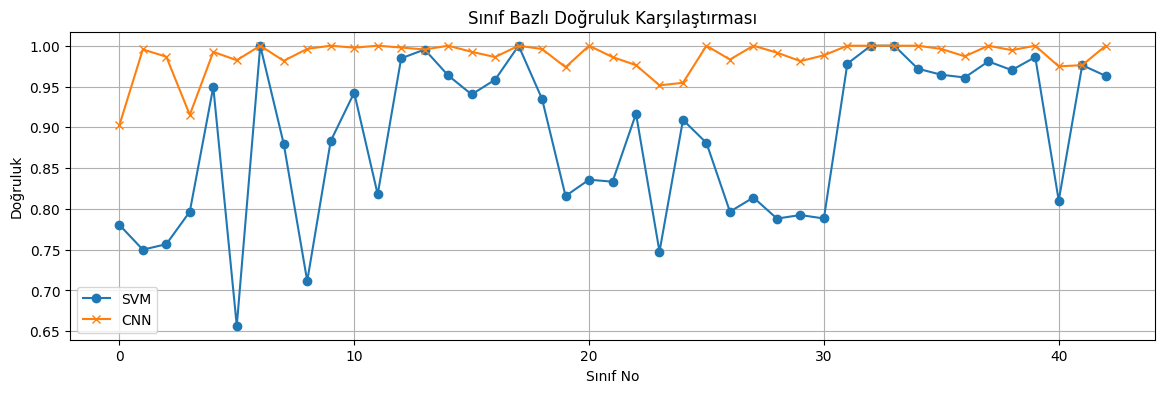

In [ ]:
# SVM için
y_pred_svm = svm.predict(X_test)
svm_class_acc = []

for c in np.unique(y_test):
    idx = y_test == c
    acc = accuracy_score(y_test[idx], y_pred_svm[idx])
    svm_class_acc.append(acc)

# CNN için
cnn_preds = np.argmax(model.predict(cnn_X_test), axis=1)
y_true_cnn = np.argmax(cnn_y_test, axis=1)
cnn_class_acc = []

for c in np.unique(y_true_cnn):
    idx = y_true_cnn == c
    acc = accuracy_score(y_true_cnn[idx], cnn_preds[idx])
    cnn_class_acc.append(acc)

# Karşılaştırmalı grafik
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(svm_class_acc, label="SVM", marker='o')
plt.plot(cnn_class_acc, label="CNN", marker='x')
plt.title("Sınıf Bazlı Doğruluk Karşılaştırması")
plt.xlabel("Sınıf No")
plt.ylabel("Doğruluk")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# %10, %30, %50 veri alt kümeleri oluştur
from sklearn.model_selection import train_test_split

# CNN için
def get_cnn_subset(percent):
    subset_X, _, subset_y, _ = train_test_split(
        cnn_X_train, cnn_y_train, train_size=percent, stratify=np.argmax(cnn_y_train, axis=1), random_state=42)
    return subset_X, subset_y

# SVM için
def get_svm_subset(percent):
    subset_X, _, subset_y, _ = train_test_split(
        X_train, y_train, train_size=percent, stratify=y_train, random_state=42)
    return subset_X, subset_y


In [ ]:
# CNN için alt veri seti oluşturma fonksiyonu
def get_cnn_subset(percent):
    subset_X, _, subset_y, _ = train_test_split(
        cnn_X_train, cnn_y_train, train_size=percent,
        stratify=np.argmax(cnn_y_train, axis=1), random_state=42)
    return subset_X, subset_y

# SVM için alt veri seti oluşturma fonksiyonu
def get_svm_subset(percent):
    subset_X, _, subset_y, _ = train_test_split(
        X_train, y_train, train_size=percent,
        stratify=y_train, random_state=42)
    return subset_X, subset_y



In [ ]:
from sklearn.model_selection import train_test_split
cnn_scores = []
svm_scores = []
sample_sizes = [0.1, 0.3, 0.5]

for p in sample_sizes:
    print(f"\n {int(p*100)}% veri ile eğitim:")

    # CNN
    sub_X_cnn, sub_y_cnn = get_cnn_subset(p)
    model_small = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(43, activation='softmax')
    ])
    model_small.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model_small.fit(sub_X_cnn, sub_y_cnn, epochs=5, batch_size=64, verbose=0)

    acc_cnn = accuracy_score(np.argmax(cnn_y_test, axis=1),
                             np.argmax(model_small.predict(cnn_X_test), axis=1))
    cnn_scores.append(acc_cnn)
    print(f"CNN doğruluk: %{acc_cnn*100:.2f}")

    # SVM
    sub_X_svm, sub_y_svm = get_svm_subset(p)
    svm_small = LinearSVC(max_iter=10000)
    svm_small.fit(sub_X_svm, sub_y_svm)
    pred_svm = svm_small.predict(X_test)
    acc_svm = accuracy_score(y_test, pred_svm)
    svm_scores.append(acc_svm)
    print(f"SVM doğruluk: %{acc_svm*100:.2f}")



 10% veri ile eğitim:


NameError: name 'cnn_X_train' is not defined